# Introduction

In machine learning with images, the place that everyone starts is with MNIST. 

The MNIST dataset is a collection of 70,000 images of handwritten digits from 0 to 9. The images are 28 by 28 pixels in size and are in grayscale. The dataset was created by combining two datasets from the National Institute of Standards and Technology (NIST). It was put together by Yann LeCun, Corinna Cortes, and Christopher J.C. Burges in 1994.

Yann LeCun also developed the convolutional neural network. Back in 2012 (an age ago in machine learning!), this network enabled him to achieve state of the art results with the famous ImageNet dataset - improving the previous year's results by over 10%. While his work has been built on and developed, the convolutional network that we will look at below has been the backbone of all computer vision (any work that involves images) ever since.

## Guide to this notebook
This notebook contains all of the code that you need to train an PyTorch model on the MNIST dataset. Assuming that you are seeing this in a Jupyter notebook, it needs three other things to train the model:
- The key Python libraries installed (as listed below).
- The `mnistdataset.py` file, which should already by here as part of the same zip file.
- The data, which again should already be here in the same zip file under the _data_ directory.

To run each cell, press the _play_ button beside each cell or select the cell and press _shift-enter_.

**Note:** the cells with code in them need to be run in the order that they come in this notebook.

My hope is that you'll play with the notebook, create new cells, tweak things and explore and, as you do so, grow in your understanding. Indeed, it would be great if this notebook became a template for you to do some experiments of your own.

# Imports
Start with imports from installed Python libraries

Key libraries to install:
- pytorch
- pandas
- numpy
- matplotlib
- sklearn

Sandboxed Python install:
- Anaconda

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

Now let's also import our dataset from the mnist_dataset.py file that we wrote earlier.

In [2]:
from mnist_dataset import MnistDataset

Here's a python hint - by typing in a function and putting a question mark after it, you get the help documentation for that function.

In [3]:
MnistDataset?

Init signature: MnistDataset(*args, **kwds)
Docstring:     
A custom PyTorch dataset class for loading the MNIST dataset.

The dataset expects to find a directory under data_root called 'train' or 'test'.
This will contain the train or the test data.

The dataset also expects to find a file called 'train.csv' or 'test.csv' in the
specified data directory.
    The 'train.csv' or 'test.csv' file should contain a column called 'png' that contains
    the name of each image file in the dataset.
    The 'train.csv' or 'test.csv' should also contain a column called 'label'
    that contains the correct label for each image in the dataset.

See mnist_dataset.ipynb for more details on this class and the csv files.

Args:
    data_root (Path or str): The root directory containing the dataset.
    mode (str): The mode of the dataset (either 'train' or 'test').

Attributes:
    data_path (Path): The path to the directory for this dataset (the train or the test dataset).
    image_info (pd.DataFra

In [4]:
GPU_AVAILABLE = torch.cuda.is_available()
GPU_AVAILABLE

True

## Load up the datasets and examine a sample datapoint

In [5]:
data_root = Path('../data')

In [6]:
test_ds = MnistDataset(data_root, 'test')
train_ds = MnistDataset(data_root, 'train')

In [7]:
sample_datapoint = train_ds[0]

In [8]:
sample_datapoint.keys()

dict_keys(['x', 'Y'])

## Define a simple 2D convolutional model

Here's a picture of the network that we're going to use. (Credit: https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/)

Below that is the code and then a line-by-line explanation of the code.

![MNIST_2D_CONV.png](MNIST_2D_CONV.png)


In [9]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding

        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14 * 14 by pooling
        # padding=2 for same padding

        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7 * 7 by pooling

        self.linear_layer1 = nn.Linear(64 * 7 * 7, 100)
        self.linear_layer2 = nn.Linear(100, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(2)
        # Note: for clarity, we're using softmax, not log_softmax here
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Layer 1:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Layer 2 (same thing but more concise code and with conv2 not conv1):
        x = self.maxpool(self.relu(self.conv2(x)))

        # Now convert from a 7x7 image to a flat 1D vector
        x = x.view(-1, 64 * 7 * 7)   # reshape Variable

        # Layer 3 (the linear layer):
        x = self.linear_layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_layer2(x)
        return self.softmax(x)

This code defines a PyTorch model class called `MnistModel` for classifying MNIST images. The model is a type of convolutional neural network (CNN), which is commonly used for image classification tasks.

Here's a breakdown of what each part of the code does:

- `class MnistModel(nn.Module):` This line defines the `MnistModel` class, which inherits from the `nn.Module` class. In PyTorch, all neural network models should inherit from `nn.Module`.
### The `__init__` method

- `def __init__(self):` This method is the initializer of the class. It's where we define the layers of the neural network.

- `super(MnistModel, self).__init__():` This line calls the initializer of the parent class (`nn.Module`). This is necessary to ensure that the `MnistModel` class is properly initialized.

- `self.conv1 = nn.Conv2d(1, 32, 5, padding=2):` This line defines a 2D convolutional layer with 1 input channel, 32 output channels, a kernel size of 5, and padding of 2. Convolutional layers are used to extract features from the input image.

- `self.conv2 = nn.Conv2d(32, 64, 5, padding=2):` This line defines another 2D convolutional layer, this time with 32 input channels and 64 output channels.

- `self.linear_layer1 = nn.Linear(64 * 7 * 7, 1024):` This line defines a linear (or fully connected) layer that takes a flat input of size 64 * 7 * 7 and outputs a vector of size 1024.

- `self.linear_layer2 = nn.Linear(1024, 10):` This line defines another linear layer that takes an input of size 1024 and outputs a vector of size 10.

- `self.relu = nn.ReLU():` This line defines a ReLU (Rectified Linear Unit) activation function, which is used to introduce non-linearity into the model.

- `self.dropout = nn.Dropout(0.5):` This line defines a dropout layer with a dropout rate of 0.5. Dropout is a regularization technique that helps to prevent overfitting.

- `self.maxpool = nn.MaxPool2d(2):` This line defines a 2D max pooling layer with a kernel size of 2. Max pooling is used to downsample the feature maps.

- `self.softmax = nn.Softmax(dim=1):` This line defines a softmax function, which is used to convert the output of the model into a probability distribution over the 10 classes.

### The `forward` method
- `def forward(self, x):` This method defines the forward pass of the model, i.e., how the input data `x` is processed by the layers of the network to produce the output.

- `x = self.conv1(x)`, `x = self.relu(x)`, `x = self.maxpool(x)`: These lines pass the input data through the first convolutional layer, apply the ReLU activation function, and then apply max pooling.

- `x = self.maxpool(self.relu(self.conv2(x)))`: This line does the same thing for the second convolutional layer, but in a more concise way.

- `x = x.view(-1, 64 * 7 * 7)`: This line reshapes the 2D feature maps into a 1D vector, which is necessary for passing the data through the linear layers.

- `x = self.linear_layer1(x)`, `x = self.relu(x)`, `x = self.dropout(x)`, `x = self.linear_layer2(x)`: These lines pass the data through the first linear layer, apply the ReLU activation function, apply dropout, and then pass the data through the second linear layer.

- `return self.softmax(x)`: This line applies the softmax function to the output of the model, converting it into a probability distribution over the 10 classes.

Now let's initialise the model.

In [10]:
model = MnistModel()
model = model.cuda() if GPU_AVAILABLE else model
model

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (linear_layer1): Linear(in_features=3136, out_features=100, bias=True)
  (linear_layer2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)

Next step - we're just going to put a single datapoint through model.

Things to note:
- To get a single datapoint into the model, we need to do the slightly weird ``unsqueeze(0)`` bit. Don't worry about that. It's just compensating for the fact that the model is expecting multiple datapoints and we're only giving it one.
- The model outputs something like confidence scores. However, to make the maths easier and faster, we usually output the log of the confidences scores. One day, when you're bored, you can look it up and see why it makes the maths so much easier and faster. So, in the real world, I'd replace `nn.Softmax` with `nn.LogSoftmax`. Further down, the loss function (`CrossEntropyLoss`) would need to be replaced with `NLLLoss`. But that's for another day!

In [11]:
x, y = sample_datapoint['x'], sample_datapoint['Y']
if GPU_AVAILABLE:
    x = x.cuda()
    y = y.cuda()
logits = model(x.unsqueeze(0))
logits

tensor([[0.1097, 0.0986, 0.0969, 0.0899, 0.0925, 0.1006, 0.1034, 0.0986, 0.1041,
         0.1057]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In the output above:
- the first figure is the model's confidence that this digit is a zero
- the second figure is the model's confidence that this digit is a 1
- and so on

We call these confidence scores "logits".

So, to get the model's prediction, we need to find which confidence score is the biggest.

In [12]:
confidence_value, prediction = torch.max(logits, dim=1)
confidence_value, prediction

(tensor([0.1097], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([0], device='cuda:0'))

## Getting the data into the model in batches

In [13]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [14]:
batch = next(iter(train_dl))
batch['x'].shape, batch['Y'].shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [15]:
# These are the correct for the first 15 images in the batch:
batch['Y'][:15]

tensor([2, 7, 8, 0, 5, 5, 2, 2, 2, 6, 2, 1, 0, 3, 9])

## Train the model



There are two more things that we need to train the model.
- The loss function compares the model's prediction with the correct answer and returns a score.
    - The absolute standard loss function is call Cross Entropy Loss and it's what we're using here.
- The Optimiser tells the model how much it should change each of its weights, based on the output of the loss function.
    - My standard is to try lots of things and almost always come back to using an Adam optimiser!
    - lr is the learning rate and it says how much the model should update itself based on the loss.
    - A higher learning rate means that that the model can learn faster but it also makes it less accurate and sometimes means that it won't train at all.

In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The following function trains a single batch of data.

There are lots of inline comments (the text following each #) to explain what it's doing.

In [17]:
def train_batch(model, batch, optimizer, loss_function):
    """
    Trains the model on a single batch of data.

    Args:
        model (nn.Module): The PyTorch model to train.
        batch (dict): A dictionary containing the input data and labels for a single batch.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        loss_function (nn.Module): The loss function to use for training.

    Returns:
        float: The loss value for the batch.
    """
    # Get the input data and labels from the batch
    x, y = batch['x'], batch['Y']
    # Move the data to the correct device, that is, onto the GPU if we have one available.
    if GPU_AVAILABLE:
        x, y = x.cuda(), y.cuda()

    # This next line is boilerplate PyTorch. It tells PyTorch to reset all gradients.
    # You'll use this line as-is most of the time.
    optimizer.zero_grad()

    # Compute the output of the model using the input data.
    output = model(x)
    # Calculate the loss using the output of the model and the correct labels.
    loss = loss_function(output, y)

    # This next lines are also boilerplate PyTorch.You'll use them as-is most of the time.
    # loss.backward() tells PyTorch to compute gradients based on the loss function.
    loss.backward()
    # optimizer.step() tells PyTorch to update the model parameters based on those gradients.
    optimizer.step()

    return loss.item()


The output of each batch is a _loss_ score.

It's a measure of how badly the model did on that batch. The larger the score, the worse the model is doing. There is a further note on loss below.

Don't worry too much about the exact number. The key thing is that, as we train multiple batches, the loss score should decrease.

In [18]:
loss = train_batch(model, batch, optimizer, loss_function)
loss

2.3027896881103516

In [19]:
def train_epoch(model, train_dl, optimizer, loss_function):
    """
    Trains the model for a single epoch.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_dl (DataLoader): The DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        loss_function (nn.Module): The loss function to use for training.

    Returns:
        float: The average loss value for the epoch.
    """
    total_loss = 0
    num_batches = len(train_dl)
    running_loss = 0
    print_every = 10
    model.train() # set model to training mode

    for i, batch in enumerate(train_dl):

        # This next line is all that we need to run through the train set once.
        batch_loss = train_batch(model, batch, optimizer, loss_function)

        # We'll keep track of the total loss so that we can calculate the average loss at the end.
        total_loss += batch_loss

        # Every so often, we'll print the average loss so far.
        # Note, the actual value of the loss won't mean very much to you.
        # The main thing is that we should see it decreasing steadily as we train.
        running_loss += batch_loss
        if (i+1) % print_every == 0:
            print(f'Batch {i+1} - Running loss: {running_loss/print_every:.3f}')
            running_loss = 0

    return total_loss / num_batches


If you don't have time to run this, we can skip the training by loading the model

In [ ]:
map_location = torch.device('cpu') if GPU_AVAILABLE else torch.device('cuda')
model.load_state_dict(torch.load('../saved_model/model.pt', map_location=torch.device('cpu')))

If you do have time to run the model, here's how you do that.

In [20]:
print(len(train_dl))
train_epoch(model, train_dl, optimizer, loss_function)

600
Batch 10 - Running loss: 2.265
Batch 20 - Running loss: 2.082
Batch 30 - Running loss: 1.916
Batch 40 - Running loss: 1.816
Batch 50 - Running loss: 1.789
Batch 60 - Running loss: 1.793
Batch 70 - Running loss: 1.758
Batch 80 - Running loss: 1.692
Batch 90 - Running loss: 1.683
Batch 100 - Running loss: 1.661
Batch 110 - Running loss: 1.661
Batch 120 - Running loss: 1.618
Batch 130 - Running loss: 1.607
Batch 140 - Running loss: 1.574
Batch 150 - Running loss: 1.567
Batch 160 - Running loss: 1.568
Batch 170 - Running loss: 1.567
Batch 180 - Running loss: 1.550
Batch 190 - Running loss: 1.536
Batch 200 - Running loss: 1.531
Batch 210 - Running loss: 1.524
Batch 220 - Running loss: 1.534
Batch 230 - Running loss: 1.529
Batch 240 - Running loss: 1.521
Batch 250 - Running loss: 1.525
Batch 260 - Running loss: 1.519
Batch 270 - Running loss: 1.515
Batch 280 - Running loss: 1.516
Batch 290 - Running loss: 1.520
Batch 300 - Running loss: 1.518
Batch 310 - Running loss: 1.513
Batch 320 - R

1.5776780200004579

In [21]:
def test_model(model, test_dl):
    """
    Tests the model on the test data.

    Args:
        model (nn.Module): The PyTorch model to test.
        test_dl (DataLoader): The DataLoader containing the test data.

    Returns:
        float: The accuracy of the model on the test data.
    """
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad(): # We don't need to calculate gradients, so we can turn them off to save memory and computation
        for batch in test_dl:
            x, y = batch['x'], batch['Y']
            if GPU_AVAILABLE:
                x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return accuracy


### Line by line explanation of the test_model function

The `test_model` function is used to evaluate the performance of a trained PyTorch model on a test dataset. Here's a breakdown of what each line does:

1. `def test_model(model, test_dl):` This line defines the function `test_model` which takes two arguments: `model` (the trained PyTorch model) and `test_dl` (a DataLoader object that loads the test data).

2. `correct = 0` and `total = 0`: These lines initialize two counters, `correct` and `total`, to 0. `correct` will keep track of the number of predictions the model gets right, and `total` will keep track of the total number of predictions.

3. `model.eval()`: This line sets the model to evaluation mode. This is necessary because some types of layers, like dropout and batch normalization, behave differently during training and evaluation.

4. `with torch.no_grad():` This line tells PyTorch not to build the computation graph during the following block of code. This is because we don't need to compute gradients during evaluation, which saves memory and computation.

5. `for batch in test_dl:` This line starts a loop over the batches of test data.

6. `x, y = batch['x'], batch['Y']`: This line unpacks the input data (`x`) and labels (`y`) from the current batch.

7. `if GPU_AVAILABLE: x, y = x.cuda(), y.cuda()`: If a GPU is available, this line moves the input data and labels to the GPU.

8. `outputs = model(x)`: This line passes the input data through the model, which computes the forward pass and returns the output.

9. `_, predicted = torch.max(outputs.data, 1)`: This line finds the index of the maximum value in the output, which corresponds to the model's prediction.

10. `total += y.size(0)`: This line increments the total count by the number of labels in the current batch.

11. `correct += (predicted == y).sum().item()`: This line increments the correct count by the number of correct predictions in the current batch.

12. `accuracy = 100 * correct / total`: This line calculates the accuracy of the model on the test data as the percentage of correct predictions.

13. `return accuracy`: This line returns the calculated accuracy.

In [22]:
test_model(model, test_dl)

97.44

Usually, we would train for a number of epochs and check our test accuracy after each one. The code would look like this:
```
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch:', epoch)
    train_epoch(model, train_dl, optimizer, loss_function)
    test_model(model, test_dl)
```

If you want to run your model for multiple epochs, paste this code into a new cell and run it.

### Saving the model

In [28]:
torch.save(model.state_dict(), '../saved_model/model.pt')


### Looking at some examples

The code below is not necessary to train the model. However, it gives us the chance to see how the model does predicting different items in the test dataset.

In [23]:
def display_prediction(model, dataset, index=None):
    """
    Displays a single digit from the test dataset and the model's prediction for it.

    Args:
        model (nn.Module): The PyTorch model to use for prediction.
        dataset (Dataset): The PyTorch dataset to use for prediction.
        index (int, optional): The index of the datapoint to display. If not provided, a random datapoint will be selected.

    Returns:
        None
    """
    # If no index has been supplied, select a random datapoint from the dataset
    idx = index if index is not None else np.random.randint(len(dataset))
    datapoint = dataset[idx]

    # Get the model's prediction for the datapoint
    x, y = datapoint['x'], datapoint['Y']
    if GPU_AVAILABLE:
        x = x.cuda()
    confidence_scores = model(x.unsqueeze(0))
    predicted_class = torch.argmax(confidence_scores, dim=1).item()

    # Display the digit and the model's prediction
    plt.imshow(x.squeeze().cpu(), cmap='gray')
    plt.title(f'Index: {idx}, True: {y.item()}, Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()


Let's display a random prediction

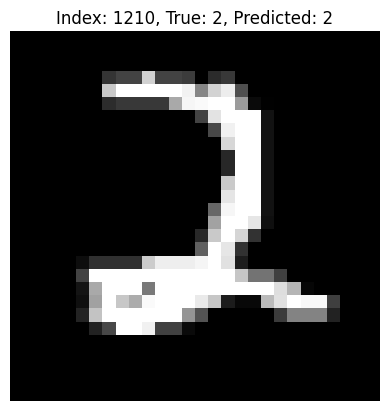

In [24]:
display_prediction(model, test_ds)

Now let's find an item that the model got wrong.

In [25]:
def find_incorrect_prediction(model: nn.Module, dataset: Dataset, num_predictions: int = 10):
    """
    Finds a specified number of incorrect predictions made by a PyTorch model on a dataset.

    Args:
        model (nn.Module): The PyTorch model to use for prediction.
        dataset (Dataset): The PyTorch dataset to use for prediction.
        num_predictions (int): The number of incorrect predictions to find.

    Returns:
        List[Tuple[int, int]]: A list of tuples containing the index of each incorrect prediction and the model's predicted class for that prediction.
    """
    # Initialize an empty list to store the incorrect predictions
    incorrect_predictions = []
    
    # Set the model to evaluation mode so that it is not learning. This will also turn off dropout.
    model.eval()
    
    # Turn off gradient calculation to save memory and computation
    with torch.no_grad():
        for i, datapoint in enumerate(dataset):

            # Get the input data and label for the datapoint
            x, y = datapoint['x'], datapoint['Y']
            # Move the input data and label to the GPU if available
            if GPU_AVAILABLE:
                x, y = x.cuda(), y.cuda()
            
            # Pass the input data through the model to get the predicted class
            confidence_scores = model(x.unsqueeze(0))
            predicted_class = torch.argmax(confidence_scores, dim=1).item()
            
            # If the predicted class is not equal to the true label, add the datapoint index and predicted class to the list of incorrect predictions
            if predicted_class != y.item():
                incorrect_predictions.append((i, y.item(), predicted_class))
                
                # If we have found the specified number of incorrect predictions, break out of the loop
                if len(incorrect_predictions) == num_predictions:
                    break

    # Return the list of incorrect predictions
    return incorrect_predictions


In [26]:
find_incorrect_prediction(model, test_ds)

[(78, 9, 8),
 (151, 9, 8),
 (241, 9, 8),
 (247, 4, 2),
 (259, 6, 0),
 (264, 9, 8),
 (290, 8, 4),
 (320, 9, 8),
 (321, 2, 7),
 (340, 5, 3)]

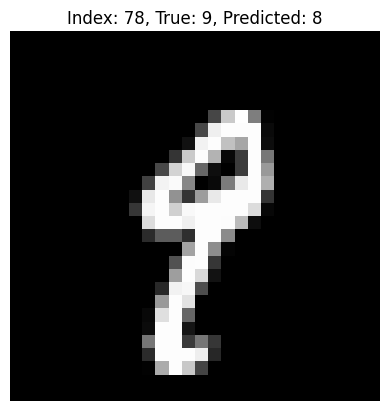

In [27]:
display_prediction(model, test_ds, 78)

### A further note on loss

Ideally, the model would produce a confidence score of 1 for the correct answer and zero for all of the others. So, if the correct answer is _2_, the model should output:

[0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0]

(Note that the first digit is the confidence score for zero, which is why the third digit actually corresponds the confidence for the number 2.)

In reality, it might produce something like this:

[0.01, 0.02, **0.91**, 0.0, 0.01, 0.005, 0.003, 0.02, 0.002, 0.02]

Note: it still got the right answer - the highest confidence score is for the number 2. However, even when it gets the right answer, unless it does it perfectly, i.e. with a confidence of 1 for the correct answer and zero for the rest, there will still be a loss.

In this way, the model learns to be more confident about the correct answer.